In [1]:
import pandas as pd
from cyvcf2 import VCF
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.stats.multitest import multipletests

In [2]:
def interval_acc(interval):
    interval = interval.replace("(","")
    interval = interval.replace(")","")
    interval = interval.split(",")
    interval = [float(n) for n in interval]
    if abs(interval[1] - interval[0]) > 0.3:
        return 0
    return 1

EAS_sistr = pd.read_csv("/gymreklab-tscc/helia/ensembl/sistr_analysis/sistr_results/EAS_sistr.txt", sep="\t")
EAS_sistr = EAS_sistr.dropna(subset=['LRT_p_value'])
EUR_sistr = pd.read_csv("/gymreklab-tscc/helia/ensembl/sistr_analysis/sistr_results/EUR_sistr.txt", sep="\t")
EUR_sistr = EUR_sistr.dropna(subset=['LRT_p_value'])

## Adjusting P-value and filtering ##
a,b,c,d = multipletests(pvals=list(pd.to_numeric(EAS_sistr['LRT_p_value'])), alpha=0.01, method="fdr_bh")
EAS_sistr['adjusted_P'] = b
a,b,c,d = multipletests(pvals=list(pd.to_numeric(EUR_sistr['LRT_p_value'])), alpha=0.01, method="fdr_bh")
EUR_sistr['adjusted_P'] = b
# EAS_sistr = EAS_sistr[EAS_sistr['adjusted_P'] < 0.01]
# EUR_sistr = EUR_sistr[EUR_sistr['adjusted_P'] < 0.01]

# ## Checking S confidence interval ## 
# EAS_sistr['interval_acc'] = EAS_sistr.apply(lambda row : interval_acc(row['ABC_s_95%_CI']), axis = 1)
# EUR_sistr['interval_acc'] = EUR_sistr.apply(lambda row : interval_acc(row['ABC_s_95%_CI']), axis = 1)
# EUR_sistr = EUR_sistr[EUR_sistr['interval_acc'] == 1]
# EAS_sistr = EAS_sistr[EAS_sistr['interval_acc'] == 1]




In [3]:
### Merging population data ###
merged_pop = pd.merge(EAS_sistr[['chrom', 'start', 'end', 'motif', 'ABC_s_median', 'adjusted_P', 'ABC_s_95%_CI']], EUR_sistr[['chrom', 'start', 'end', 'motif', 'ABC_s_median','adjusted_P','ABC_s_95%_CI']], on = ['chrom','start','end', 'motif'], how="inner", suffixes= ['_EAS', '_EUR'])
merged_pop['end'] = merged_pop['end'] - 1

In [4]:
### Loading coding regions and add name of genes to them ####
coding_overlaps = pd.read_csv("../1000Genomes-TR-Analysis/stats/coding_overlap/Supplementary_Table_7.csv", sep = "\t")
coding_overlaps = coding_overlaps[(coding_overlaps['motif'].str.len() > 1) & (coding_overlaps['motif'].str.len() < 5)]
coding_overlaps['gene_name_gencode'] = coding_overlaps['gene_name'].str.split("_").str[0]
print(len(coding_overlaps))
gene_names = pd.read_csv("gencode.v41.metadata.HGNC", sep = "\t", header=None)
gene_names.columns = ["gene_name_gencode","gene_symbol","some"]
gene_names = gene_names[["gene_name_gencode","gene_symbol"]]
coding_overlaps = pd.merge(coding_overlaps, gene_names, on = "gene_name_gencode", how = "left")
coding_overlaps.to_csv("name_coding.csv",index=False)


5320


In [5]:
### Load African results ###

AFR_sistr = pd.read_csv("/gymreklab-tscc/helia/ensembl/sistr_analysis/sistr_results/AFR_sistr_coding.txt", sep="\t")
AFR_sistr = AFR_sistr.dropna(subset=['LRT_p_value'])


a,b,c,d = multipletests(pvals=list(pd.to_numeric(AFR_sistr['LRT_p_value'])), alpha=0.01, method="fdr_bh")
AFR_sistr['adjusted_P_AFR'] = b

In [7]:
coding_selection_info = pd.merge(merged_pop, coding_overlaps, on = ['chrom','start','end','motif'])

## Add african
coding_selection_info_all = pd.merge(AFR_sistr[['chrom', 'start', 'end', 'motif',
                                                'ABC_s_median', 'adjusted_P_AFR', 'ABC_s_95%_CI']],
                                     coding_selection_info, left_on = ['chrom','start','end','motif'],
                                    right_on=['chrom','start','end','motif'])
coding_selection_info_all = coding_selection_info_all[(coding_selection_info_all['adjusted_P_EUR'] < 0.01) |
                                              (coding_selection_info_all['adjusted_P_EAS'] < 0.01) | 
                                              (coding_selection_info_all['adjusted_P_AFR'] < 0.01)]
coding_selection_info_all

,chrom,start,end,motif,ABC_s_median,adjusted_P_AFR,ABC_s_95%_CI,ABC_s_median_EAS,adjusted_P_EAS,ABC_s_95%_CI_EAS,...,adjusted_P_EUR,ABC_s_95%_CI_EUR,gene_name,EUR_het,SAS_het,EAS_het,AMR_het,AFR_het,gene_name_gencode,gene_symbol
0,chr1,970841,970857,AC,0.18099,0.000209,"(0.0625 , 0.74413)",0.19278,0.000105,"(0.06418 , 0.77388)",...,0.000107,"(0.06418 , 0.77388)",ENST00000379409.6_cds_4_0_chr1_970686_f,0.00000,0.00000,0.00000,0.00000,0.00000,ENST00000379409.6,PLEKHN1
3,chr1,1285956,1285981,ACC,0.13780,0.000209,"(0.04296 , 0.61778)",0.14577,0.000105,"(0.04266 , 0.66341)",...,0.000107,"(0.04266 , 0.66341)",ENST00000470022.1_cds_3_0_chr1_1285926_f,0.00000,0.00000,0.00000,0.00000,0.00000,ENST00000470022.1,SCNN1D
4,chr1,1333607,1333633,AGC,0.23946,0.000209,"(0.08738 , 0.75364)",0.23488,0.000107,"(0.09021 , 0.84518)",...,0.000109,"(0.09021 , 0.84518)",ENST00000339381.6_cds_5_0_chr1_1333506_f,0.00788,0.00334,0.01700,0.10600,0.00112,ENST00000339381.6,TAS1R3
5,chr1,1399284,1399304,CCG,0.08916,0.000209,"(0.01353 , 0.58259)",0.01205,0.023042,"(0 , 0.14476)",...,0.000607,"(0.00766 , 0.5744)",ENST00000425598.2_cds_4_0_chr1_1398988_r,0.00787,0.00000,0.00341,0.00611,0.00670,ENST00000425598.2,CCNL2
6,chr1,1420235,1420246,CCCG,0.23036,0.000209,"(0.08391 , 0.70598)",0.22997,0.000105,"(0.08377 , 0.78128)",...,0.000107,"(0.08377 , 0.78128)",ENST00000454272.2_cds_1_0_chr1_1420052_r,0.00000,0.00000,0.00000,0.00000,0.00000,ENST00000454272.2,ANKRD65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4890,chr22,46280214,46280231,AGGC,0.23036,0.000209,"(0.08391 , 0.70598)",0.22997,0.000105,"(0.08377 , 0.78128)",...,0.000107,"(0.08377 , 0.78128)",ENST00000421359.5_cds_6_0_chr22_46280069_f,0.00000,0.00000,0.00000,0.00000,0.00112,ENST00000421359.5,TTC38
4895,chr22,50114421,50114432,AGCC,0.23036,0.000209,"(0.08391 , 0.70598)",0.22997,0.000105,"(0.08377 , 0.78128)",...,0.000107,"(0.08377 , 0.78128)",ENST00000262794.10_cds_6_0_chr22_50114381_f,0.00000,0.00000,0.00000,0.00000,0.00000,ENST00000262794.10,MOV10L1
4897,chr22,50261486,50261497,CCCG,0.23036,0.000209,"(0.08391 , 0.70598)",0.22997,0.000105,"(0.08377 , 0.78128)",...,0.000107,"(0.08377 , 0.78128)",ENST00000215659.13_cds_11_0_chr22_50261385_r,0.00000,0.00000,0.00000,0.00000,0.00000,ENST00000215659.13,MAPK12
4899,chr22,50482844,50482855,CCGG,0.23036,0.000209,"(0.08391 , 0.70598)",0.22997,0.000105,"(0.08377 , 0.78128)",...,0.000107,"(0.04662 , 0.63086)",ENST00000395737.2_cds_2_0_chr22_50482567_f,0.00158,0.00000,0.00000,0.00000,0.00000,ENST00000395737.2,ADM2


In [13]:
### Only in European ###
only_EUR = coding_selection_info_all[(coding_selection_info_all['adjusted_P_EUR'] < 0.01) & 
                      (coding_selection_info_all['adjusted_P_EAS'] > 0.01) & 
                      (coding_selection_info_all['adjusted_P_AFR'] > 0.01)]

pd.set_option('display.max_rows', 100)
display(only_EUR[['chrom','start','end','motif','gene_name','gene_symbol','adjusted_P_EAS', 'adjusted_P_AFR','adjusted_P_EUR']])
# only_EUR.sort_values('adjusted_P_EUR').reset_index(drop=True)[['chrom','start','end','motif','gene_name',
#                                                                'gene_symbol','ABC_s_median_EAS','adjusted_P_EAS',
#                                                                'ABC_s_95%_CI_EAS','ABC_s_median_EUR','adjusted_P_EUR',
#                                                                'ABC_s_95%_CI_EUR']].to_csv("selected_genes_in_EUR.csv", sep = "\t", index = False)

,chrom,start,end,motif,gene_name,gene_symbol,adjusted_P_EAS,adjusted_P_AFR,adjusted_P_EUR
586,chr2,32947622,32947642,CCG,ENST00000404816.7_cds_0_0_chr2_32947325_f,LTBP1,0.291244,1.000000,0.005818
683,chr2,104855919,104855943,CCG,ENST00000361360.4_cds_0_0_chr2_104855511_f,POU3F3,0.397820,0.261411,0.000107
1588,chr6,7727279,7727310,AGC,ENST00000283147.7_cds_0_0_chr6_7726956_f,BMP6,0.010721,0.014031,0.001607
1806,chr6,156778032,156778052,AGG,ENST00000346085.10_cds_1_0_chr6_156777681_f,ARID1B,0.100642,0.226416,0.000607
1971,chr7,100966482,100966503,AGC,ENST00000379458.9_cds_8_0_chr7_100966386_f,MUC3A,0.023042,0.017705,0.000607
2225,chr8,144440081,144440102,AGG,ENST00000409379.8_cds_15_0_chr8_144440021_r,TONSL,1.000000,0.277104,0.000607
2567,chr10,117134314,117134337,CCG,ENST00000369206.6_cds_0_0_chr10_117134008_r,VAX1,1.000000,0.279226,0.000107
3221,chr13,114291708,114291729,AAG,ENST00000351487.5_cds_5_0_chr13_114291634_f,UPF3A,0.186257,0.060391,0.005818
4237,chr19,1578373,1578393,AGG,ENST00000156825.5_cds_1_0_chr19_1578340_r,MBD3,1.000000,0.337342,0.000607
4642,chr20,19212876,19212898,CCG,ENST00000328041.11_cds_0_0_chr20_19212843_f,SLC24A3,1.000000,0.304036,0.000607


In [14]:
### Only in East Asian ###
only_EAS = coding_selection_info_all[(coding_selection_info_all['adjusted_P_EAS'] < 0.01) & 
                      (coding_selection_info_all['adjusted_P_EUR'] > 0.01) & 
                      (coding_selection_info_all['adjusted_P_AFR'] > 0.01)]

pd.set_option('display.max_rows', 100)
display(only_EAS[['chrom','start','end','motif','gene_name','gene_symbol','adjusted_P_EAS', 'adjusted_P_AFR','adjusted_P_EUR']])



,chrom,start,end,motif,gene_name,gene_symbol,adjusted_P_EAS,adjusted_P_AFR,adjusted_P_EUR
11,chr1,1752909,1752936,AGG,ENST00000341426.9_cds_0_0_chr1_1752904_r,NADK,0.000635,0.092423,0.321045
23,chr1,4712523,4712544,ACC,ENST00000378190.7_cds_1_0_chr1_4711900_f,AJAP1,0.005746,1.000000,0.183263
128,chr1,27548842,27548862,AGG,ENST00000247087.10_cds_1_0_chr1_27547304_r,AHDC1,0.005746,0.058470,0.020777
1167,chr4,7192755,7192775,AGC,ENST00000507866.6_cds_0_0_chr4_7192647_f,SORCS2,0.000599,0.064881,0.090378
1396,chr5,73447061,73447081,CCG,ENST00000615637.3_cds_0_0_chr5_73446965_r,FOXD1,0.000599,0.224101,0.090378
1618,chr6,29657251,29657276,AGG,ENST00000376888.6_cds_0_0_chr6_29657210_f,MOG,0.009239,1.000000,0.102217
2007,chr7,129189199,129189220,AGC,ENST00000249373.8_cds_0_0_chr7_129189152_f,SMO,0.005746,0.275154,0.225709
2016,chr7,137846770,137846790,CCG,ENST00000288490.9_cds_33_0_chr7_137846462_r,DGKI,0.005746,0.092423,0.070371
2049,chr7,154968831,154968853,AGC,ENST00000397192.5_cds_14_0_chr7_154968403_r,PAXIP1,0.000599,0.224101,0.020777
2204,chr8,143429783,143429813,ACC,ENST00000333480.3_cds_0_0_chr8_143429345_r,MAFA,0.000105,0.076788,0.027219


In [22]:
### significant all ###
all_sig = coding_selection_info_all[(coding_selection_info_all['adjusted_P_EAS'] < 0.01) & 
                      (coding_selection_info_all['adjusted_P_EUR'] < 0.01) & 
                      (coding_selection_info_all['adjusted_P_AFR'] < 0.01)]

display(all_sig[['chrom','start','end','motif','gene_name','gene_symbol','adjusted_P_EAS', 'adjusted_P_AFR','adjusted_P_EUR']])



,chrom,start,end,motif,gene_name,gene_symbol,adjusted_P_EAS,adjusted_P_AFR,adjusted_P_EUR
0,chr1,970841,970857,AC,ENST00000379409.6_cds_4_0_chr1_970686_f,PLEKHN1,0.000105,0.000209,0.000107
3,chr1,1285956,1285981,ACC,ENST00000470022.1_cds_3_0_chr1_1285926_f,SCNN1D,0.000105,0.000209,0.000107
4,chr1,1333607,1333633,AGC,ENST00000339381.6_cds_5_0_chr1_1333506_f,TAS1R3,0.000107,0.000209,0.000109
6,chr1,1420235,1420246,CCCG,ENST00000454272.2_cds_1_0_chr1_1420052_r,ANKRD65,0.000105,0.000209,0.000107
12,chr1,2082398,2082409,AAAT,ENST00000481140.5_cds_0_0_chr1_2082321_f,PRKCZ,0.000105,0.000209,0.000107
...,...,...,...,...,...,...,...,...,...
4890,chr22,46280214,46280231,AGGC,ENST00000421359.5_cds_6_0_chr22_46280069_f,TTC38,0.000105,0.000209,0.000107
4895,chr22,50114421,50114432,AGCC,ENST00000262794.10_cds_6_0_chr22_50114381_f,MOV10L1,0.000105,0.000209,0.000107
4897,chr22,50261486,50261497,CCCG,ENST00000215659.13_cds_11_0_chr22_50261385_r,MAPK12,0.000105,0.000209,0.000107
4899,chr22,50482844,50482855,CCGG,ENST00000395737.2_cds_2_0_chr22_50482567_f,ADM2,0.000105,0.000209,0.000107


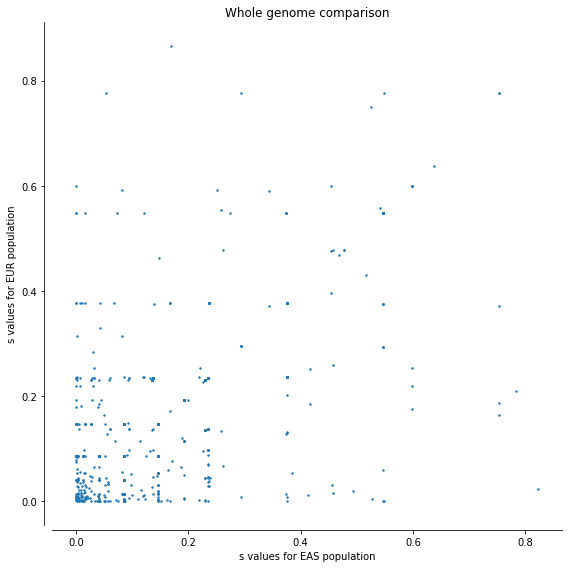

In [130]:
fig, ax = plt.subplots(figsize=(8, 8))
    
# ax.set_xscale("log",basex=)
# ax.set_yscale("log",basey=10)
# ax.set_xlim(min(coding_selection_info['ABC_s_median_EAS']), max(coding_selection_info['ABC_s_median_EAS']))
# ax.set_ylim(min(coding_selection_info['ABC_s_median_EUR']), max(coding_selection_info['ABC_s_median_EUR']))
ax.scatter(coding_selection_info['ABC_s_median_EAS'], coding_selection_info['ABC_s_median_EUR'],s = 2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))
ax.set_title("Whole genome comparison")
ax.set_xlabel("s values for EAS population")
ax.set_ylabel("s values for EUR population")

ax.axis('tight')
plt.tight_layout()

In [154]:
### Reading Melissa favorite loci ####
loci = []
locus_list = []
with open("Melissa_sistr_loci.txt") as f:
    cnt = 0
    for line in f:
        if len(line.split(":")) == 2 and line.split(":")[0].isnumeric():
            loci.append(locus_list)
            locus_list = []
            locus_list.extend(line.strip().split(":"))
            cnt += 1
        else:
            if len(line) < 2:
                cnt += 1
                continue
            locus_list.append(line.strip())
            cnt += 1
            
loci = pd.DataFrame(loci[1:], columns = ['chrom', 'start', 'gene_name', 's-value', 'pLI', 
                                         'Known phenotype associations (OMIM)']) 
loci['start'] = pd.to_numeric(loci['start'])
loci['chrom'] = "chr" + loci['chrom']
loci[['gene_symbol','ru']] = loci['gene_name'].str.split(" ", expand=True)


melissa_loci_new_results = pd.merge(loci, coding_selection_info, how = 'left', on = ["gene_symbol",'chrom','start'])[['chrom','start','end','motif',
                                                               'gene_symbol','s-value','pLI','ABC_s_median_EAS','adjusted_P_EAS',
                                                               'ABC_s_95%_CI_EAS','ABC_s_median_EUR','adjusted_P_EUR',
                                                               'ABC_s_95%_CI_EUR']].to_csv("Melissa_loci_selection.csv", sep = "\t", index = False)




In [19]:
##### limit sistr input to coding loci #####

sistr_input_AFR = pd.read_csv("/gymreklab-tscc/helia/ensembl/sistr_analysis/al_freqs/AFR_sistr_input.txt", sep = "\t", header = None)
sistr_input_AFR = sistr_input_AFR.drop_duplicates(subset = [0,1,2])
sistr_input_AFR[2] = pd.to_numeric(sistr_input_AFR[2]) - 1
coding_overlaps = pd.read_csv("../1000Genomes-TR-Analysis/stats/coding_overlap/Supplementary_Table_7.csv", sep = "\t")

In [26]:
sistr_input_AFR_coding = pd.merge(sistr_input_AFR, coding_overlaps, left_on = [0,1,2], right_on = ['chrom','start','end'])
sistr_input_AFR_coding = sistr_input_AFR_coding[[0,1,2,3,4,5,6]]
sistr_input_AFR_coding.to_csv("/gymreklab-tscc/helia/AFR_sistr_input_coding.csv", sep = "\t", index = False, header=False)